# 18.2 Estimating Heterogeneity

**Chapter**: 18 - Heterogeneous Treatment Effects  
**Section**: 2 - Estimating Heterogeneity  
**Facure Source**: 18-Heterogeneous-Treatment-Effects-and-Personalization.ipynb  
**Version**: 1.0.0  
**Last Validated**: 2026-01-16

---

## Table of Contents

1. [Facure's Intuition](#1-facures-intuition)
   - 1.1 [Predicting the Unobservable](#11-predicting-the-unobservable)
   - 1.2 [Interaction Terms](#12-interaction-terms)
2. [Formal Treatment](#2-formal-treatment)
   - 2.1 [The Derivative Approach](#21-the-derivative-approach)
   - 2.2 [Model Specification](#22-model-specification)
3. [Implementation](#3-implementation)
   - 3.1 [Building CATE Models](#31-building-cate-models)
   - 3.2 [Sensitivity Predictions](#32-sensitivity-predictions)
4. [Numeric Demonstration](#4-numeric-demonstration)
5. [Interview Appendix](#5-interview-appendix)
6. [References](#6-references)

---

In [1]:
# Standard imports via common module
import sys
sys.path.insert(0, '../..')

from facure_augment.common import (
    np, pd, plt, sm, stats,
    load_facure_data,
    set_notebook_style,
    create_tufte_figure,
    apply_tufte_style,
    TUFTE_PALETTE,
    COLORS,
)

import statsmodels.formula.api as smf
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split

set_notebook_style()
np.random.seed(123)

print("Imports loaded successfully")

Imports loaded successfully


---

## 1. Facure's Intuition

> **Interview Relevance**: Understanding how to predict individual treatment sensitivity — even though it's unobservable — is key to many industry applications of causal inference.

### 1.1 Predicting the Unobservable

We want to predict $\frac{\partial Y_i}{\partial T_i}$ — individual sensitivity to treatment. But this is **unobservable** (we can't see the same unit under different treatments).

**Key insight**: We don't need to OBSERVE sensitivity to PREDICT it!

If we have a model that predicts $\hat{Y}$ from $X$ and $T$, we can compute:

$$\widehat{\frac{\partial Y}{\partial T}} = \frac{\hat{Y}(T + \epsilon) - \hat{Y}(T)}{\epsilon}$$

This is a numerical approximation of the derivative — our predicted sensitivity.

### 1.2 Interaction Terms

Consider a linear model:

$$Y_i = \beta_0 + \beta_1 T_i + \beta_2 X_i + \epsilon_i$$

Taking the derivative:

$$\frac{\partial Y_i}{\partial T_i} = \beta_1$$

Everyone has the same sensitivity! This is the **ATE** model.

Now add an **interaction**:

$$Y_i = \beta_0 + \beta_1 T_i + \beta_2 X_i + \beta_3 (T_i \cdot X_i) + \epsilon_i$$

Taking the derivative:

$$\frac{\partial Y_i}{\partial T_i} = \beta_1 + \beta_3 X_i$$

Now sensitivity varies with $X$! This is a **CATE** model.

In [2]:
# Load the ice cream sales data
prices_rnd = load_facure_data('ice_cream_sales_rnd.csv')

# Split into train/test for model comparison
train, test = train_test_split(prices_rnd, test_size=0.25, random_state=123)

print("=" * 60)
print("DATA SETUP")
print("=" * 60)
print(f"\nTraining set: {len(train):,} observations")
print(f"Test set: {len(test):,} observations")
print(f"\nOutcome: sales")
print(f"Treatment: price")
print(f"Features: temp, weekday, cost")

DATA SETUP

Training set: 3,750 observations
Test set: 1,250 observations

Outcome: sales
Treatment: price
Features: temp, weekday, cost


---

## 2. Formal Treatment

### 2.1 The Derivative Approach

For any outcome model $\mu(X, T)$, we can define **sensitivity** as:

$$\tau(x) = \frac{\partial \mu(x, t)}{\partial t}$$

**For linear models**, this derivative has a closed form:

| Model | Sensitivity |
|-------|-------------|
| $Y = \beta_0 + \beta_1 T + \beta_2 X$ | $\beta_1$ (constant) |
| $Y = \beta_0 + \beta_1 T + \beta_3 TX$ | $\beta_1 + \beta_3 X$ (linear in X) |
| $Y = f(T, X)$ (nonlinear) | Numerical approximation |

**Numerical approximation** (general):

$$\hat{\tau}(x) = \frac{\hat{\mu}(x, t + h) - \hat{\mu}(x, t)}{h}$$

With $h$ small (e.g., 0.01 or 1).

### 2.2 Model Specification

We'll build three models of increasing complexity:

**Model 1 (ATE)**: No interactions
$$\text{sales} = \beta_0 + \beta_1 \text{price} + \beta_2 \text{temp} + \beta_3 \text{weekday} + \beta_4 \text{cost} + \epsilon$$

**Model 2 (CATE with temp)**: One interaction
$$\text{sales} = \beta_0 + \beta_1 \text{price} + \beta_2 \text{price} \times \text{temp} + \text{controls} + \epsilon$$

**Model 3 (Full CATE)**: All interactions
$$\text{sales} = \beta_0 + \beta_1 \text{price} + \beta_2 \text{price} \times \text{temp} + \beta_3 \text{price} \times \text{cost} + \beta_4 \text{price} \times \text{weekday} + \epsilon$$

---

## 3. Implementation

### 3.1 Building CATE Models

In [3]:
# Model 1: ATE model (constant effect)
m1 = smf.ols("sales ~ price + temp + C(weekday) + cost", data=train).fit()

print("=" * 60)
print("MODEL 1: ATE (No Interactions)")
print("=" * 60)
print(f"\nsales = β₀ + β₁·price + β₂·temp + weekday_dummies + β₄·cost")
print(f"\nPrice coefficient: {m1.params['price']:.4f}")
print(f"\nPredicted sensitivity: {m1.params['price']:.2f} for ALL days")

MODEL 1: ATE (No Interactions)

sales = β₀ + β₁·price + β₂·temp + weekday_dummies + β₄·cost

Price coefficient: -2.7515

Predicted sensitivity: -2.75 for ALL days


In [4]:
# Model 2: CATE with temperature interaction
m2 = smf.ols("sales ~ price*temp + C(weekday) + cost", data=train).fit()

print("=" * 60)
print("MODEL 2: CATE (Price × Temperature)")
print("=" * 60)
print(f"\nPrice coefficient (base): {m2.params['price']:.4f}")
print(f"Price × temp interaction: {m2.params['price:temp']:.4f}")
print(f"\nSensitivity = {m2.params['price']:.2f} + {m2.params['price:temp']:.4f} × temp")
print(f"\nExamples:")
print(f"  At 20°C: {m2.params['price'] + m2.params['price:temp']*20:.2f}")
print(f"  At 25°C: {m2.params['price'] + m2.params['price:temp']*25:.2f}")
print(f"  At 30°C: {m2.params['price'] + m2.params['price:temp']*30:.2f}")

MODEL 2: CATE (Price × Temperature)

Price coefficient (base): -3.6299
Price × temp interaction: 0.0366

Sensitivity = -3.63 + 0.0366 × temp

Examples:
  At 20°C: -2.90
  At 25°C: -2.72
  At 30°C: -2.53


In [5]:
# Model 3: Full CATE with all interactions
m3 = smf.ols("sales ~ price*cost + price*C(weekday) + price*temp", data=train).fit()

print("=" * 60)
print("MODEL 3: Full CATE (All Interactions)")
print("=" * 60)
print(f"\nPrice coefficient (base): {m3.params['price']:.4f}")
print(f"Price × temp: {m3.params['price:temp']:.4f}")
print(f"Price × cost: {m3.params['price:cost']:.4f}")
print(f"\nSensitivity varies with temp, cost, AND weekday")

MODEL 3: Full CATE (All Interactions)

Price coefficient (base): -11.2623
Price × temp: 0.0495
Price × cost: 0.2722

Sensitivity varies with temp, cost, AND weekday


### 3.2 Sensitivity Predictions

In [6]:
def pred_sensitivity(model, df, t_col="price", h=1):
    """
    Predict sensitivity using numerical derivative approximation.
    
    Parameters
    ----------
    model : fitted statsmodels model
    df : DataFrame with features
    t_col : name of treatment column
    h : step size for numerical derivative (default 1)
    
    Returns
    -------
    DataFrame with pred_sens column added
    """
    df_plus = df.copy()
    df_plus[t_col] = df[t_col] + h
    return df.assign(
        pred_sens=(model.predict(df_plus) - model.predict(df)) / h
    )

# Make predictions on test set
test_m1 = pred_sensitivity(m1, test)
test_m2 = pred_sensitivity(m2, test)
test_m3 = pred_sensitivity(m3, test)

print("Sensitivity predictions on test set:")
print(f"\nModel 1 (ATE):       mean={test_m1['pred_sens'].mean():.3f}, std={test_m1['pred_sens'].std():.3f}")
print(f"Model 2 (temp):      mean={test_m2['pred_sens'].mean():.3f}, std={test_m2['pred_sens'].std():.3f}")
print(f"Model 3 (full):      mean={test_m3['pred_sens'].mean():.3f}, std={test_m3['pred_sens'].std():.3f}")

Sensitivity predictions on test set:

Model 1 (ATE):       mean=-2.751, std=0.000
Model 2 (temp):      mean=-2.759, std=0.148
Model 3 (full):      mean=-2.509, std=4.522


In [7]:
# Show sample predictions
sample = test_m3.sample(5, random_state=1)[['temp', 'weekday', 'cost', 'price', 'sales', 'pred_sens']]
print("Sample predictions (Model 3):")
print(sample.round(2))

print("\n" + "=" * 60)
print("INTERPRETATION")
print("=" * 60)
print("\npred_sens = predicted change in sales per $1 price increase")
print("Negative values = sales decrease when price increases (expected)")
print("More negative = more price sensitive")
print("Less negative (or positive) = less price sensitive")

Sample predictions (Model 3):
        temp  weekday   cost  price  sales  pred_sens
4764 31.1000        6 1.0000      3    212     1.1400
4324 24.8000        7 0.5000     10    182    -9.9900
4536 25.0000        2 1.5000      6    205     0.2800
3466 26.0000        3 1.5000      3    205     0.3100
115  19.3000        3 0.3000      9    177    -0.3500

INTERPRETATION

pred_sens = predicted change in sales per $1 price increase
Negative values = sales decrease when price increases (expected)
More negative = more price sensitive
Less negative (or positive) = less price sensitive


---

## 4. Numeric Demonstration

Let's visualize how the models differ in their heterogeneity predictions.

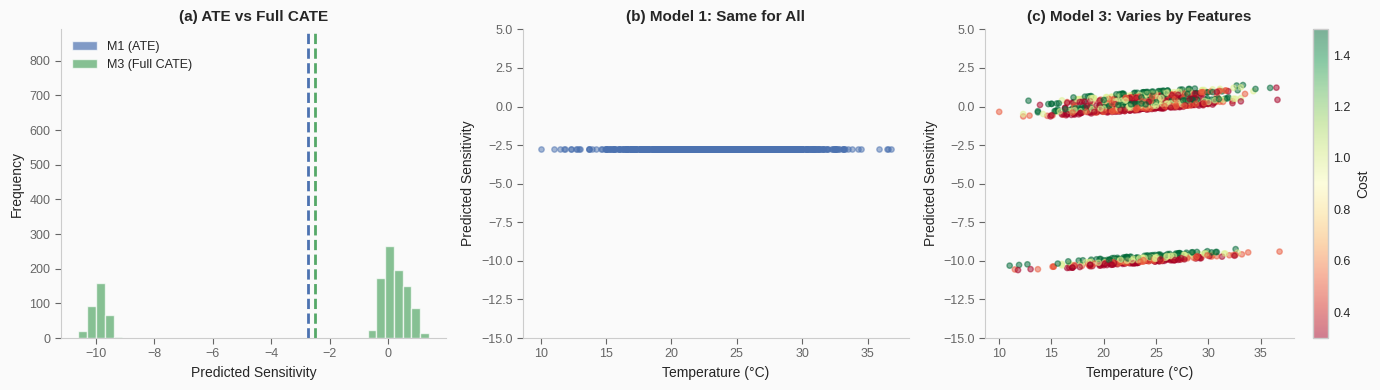


Key observation:
  - Model 1 gives the SAME prediction for everyone (vertical line)
  - Model 3 predictions vary with temperature AND cost (colored spread)


In [8]:
# Compare sensitivity predictions across models
fig, axes = create_tufte_figure(1, 3, figsize=(14, 4))

# Panel 1: Distribution comparison
ax = axes[0]
ax.hist(test_m1['pred_sens'], bins=20, alpha=0.7, label='M1 (ATE)', color=COLORS['blue'], edgecolor='white')
ax.hist(test_m3['pred_sens'], bins=40, alpha=0.7, label='M3 (Full CATE)', color=COLORS['green'], edgecolor='white')
ax.axvline(test_m1['pred_sens'].mean(), color=COLORS['blue'], ls='--', lw=2)
ax.axvline(test_m3['pred_sens'].mean(), color=COLORS['green'], ls='--', lw=2)
ax.set_xlabel('Predicted Sensitivity')
ax.set_ylabel('Frequency')
ax.set_title('(a) ATE vs Full CATE', fontweight='bold')
ax.legend(frameon=False)

# Panel 2: M1 predictions (constant)
ax = axes[1]
ax.scatter(test_m1['temp'], test_m1['pred_sens'], alpha=0.5, s=15, c=COLORS['blue'])
ax.set_xlabel('Temperature (°C)')
ax.set_ylabel('Predicted Sensitivity')
ax.set_title('(b) Model 1: Same for All', fontweight='bold')
ax.set_ylim(-15, 5)

# Panel 3: M3 predictions (heterogeneous)
ax = axes[2]
scatter = ax.scatter(test_m3['temp'], test_m3['pred_sens'], alpha=0.5, s=15, 
                     c=test_m3['cost'], cmap='RdYlGn')
ax.set_xlabel('Temperature (°C)')
ax.set_ylabel('Predicted Sensitivity')
ax.set_title('(c) Model 3: Varies by Features', fontweight='bold')
ax.set_ylim(-15, 5)
cbar = plt.colorbar(scatter, ax=ax)
cbar.set_label('Cost')

plt.tight_layout()
plt.show()

print("\nKey observation:")
print("  - Model 1 gives the SAME prediction for everyone (vertical line)")
print("  - Model 3 predictions vary with temperature AND cost (colored spread)")

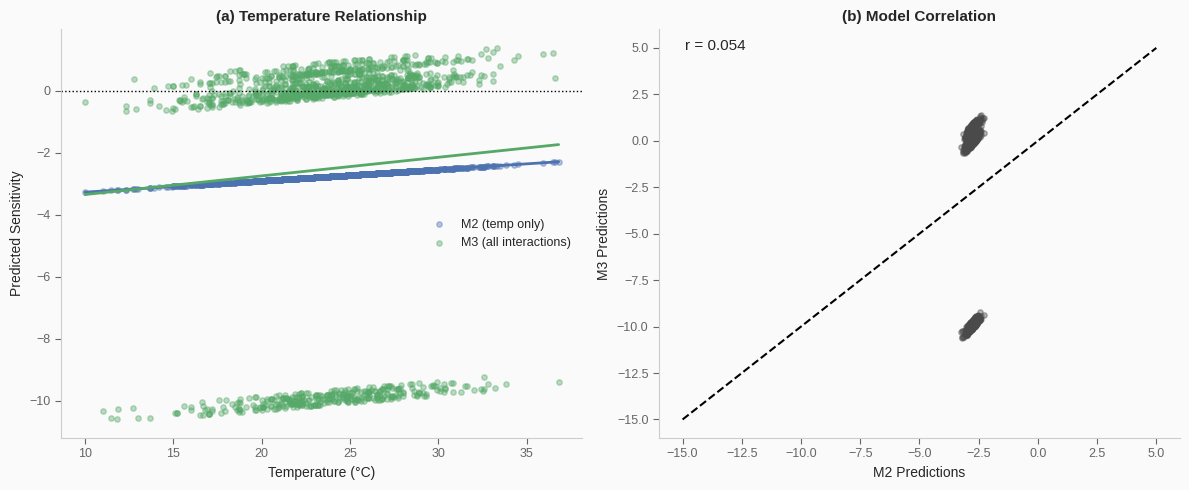


Correlation between M2 and M3 predictions: 0.054
Model 3 adds variation from cost and weekday interactions.


In [9]:
# Compare model 2 and model 3
fig, axes = create_tufte_figure(1, 2, figsize=(12, 5))

# Panel 1: Sensitivity vs Temperature (both models)
ax = axes[0]
ax.scatter(test_m2['temp'], test_m2['pred_sens'], alpha=0.4, s=15, 
           c=COLORS['blue'], label='M2 (temp only)')
ax.scatter(test_m3['temp'], test_m3['pred_sens'], alpha=0.4, s=15, 
           c=COLORS['green'], label='M3 (all interactions)')

# Add trend lines
z2 = np.polyfit(test_m2['temp'], test_m2['pred_sens'], 1)
z3 = np.polyfit(test_m3['temp'], test_m3['pred_sens'], 1)
temp_range = np.linspace(test['temp'].min(), test['temp'].max(), 100)
ax.plot(temp_range, np.poly1d(z2)(temp_range), c=COLORS['blue'], lw=2, ls='-')
ax.plot(temp_range, np.poly1d(z3)(temp_range), c=COLORS['green'], lw=2, ls='-')

ax.axhline(0, color='black', ls=':', lw=1)
ax.set_xlabel('Temperature (°C)')
ax.set_ylabel('Predicted Sensitivity')
ax.set_title('(a) Temperature Relationship', fontweight='bold')
ax.legend(frameon=False)

# Panel 2: Prediction correlation
ax = axes[1]
ax.scatter(test_m2['pred_sens'], test_m3['pred_sens'], alpha=0.4, s=15, 
           c=TUFTE_PALETTE['primary'])
ax.plot([-15, 5], [-15, 5], 'k--', lw=1.5, label='45° line')
ax.set_xlabel('M2 Predictions')
ax.set_ylabel('M3 Predictions')
ax.set_title('(b) Model Correlation', fontweight='bold')

corr = np.corrcoef(test_m2['pred_sens'], test_m3['pred_sens'])[0, 1]
ax.text(0.05, 0.95, f'r = {corr:.3f}', transform=ax.transAxes, fontsize=11)

plt.tight_layout()
plt.show()

print(f"\nCorrelation between M2 and M3 predictions: {corr:.3f}")
print("Model 3 adds variation from cost and weekday interactions.")

In [10]:
# Create sensitivity bands for personalization
test_m3['sens_band'] = pd.qcut(test_m3['pred_sens'], q=3, 
                               labels=['High Sensitivity', 'Medium', 'Low Sensitivity'])

print("=" * 60)
print("SENSITIVITY BANDS (Model 3)")
print("=" * 60)

summary = test_m3.groupby('sens_band').agg({
    'pred_sens': ['mean', 'min', 'max'],
    'temp': 'mean',
    'cost': 'mean',
    'sales': 'mean'
}).round(2)

print(summary)

print("\n" + "=" * 60)
print("INSIGHTS")
print("=" * 60)
print("\nHigh sensitivity band: cooler days, higher cost")
print("  -> These days: keep prices LOW")
print("\nLow sensitivity band: hotter days, lower cost")
print("  -> These days: can RAISE prices")

SENSITIVITY BANDS (Model 3)
                 pred_sens                     temp   cost    sales
                      mean      min     max    mean   mean     mean
sens_band                                                          
High Sensitivity   -8.1100 -10.6000 -0.2800 22.6700 0.7600 211.6800
Medium             -0.0100  -0.2700  0.2300 23.4900 0.7500 193.2100
Low Sensitivity     0.5900   0.2300  1.3900 25.3500 0.9200 200.0800

INSIGHTS

High sensitivity band: cooler days, higher cost
  -> These days: keep prices LOW

Low sensitivity band: hotter days, lower cost
  -> These days: can RAISE prices


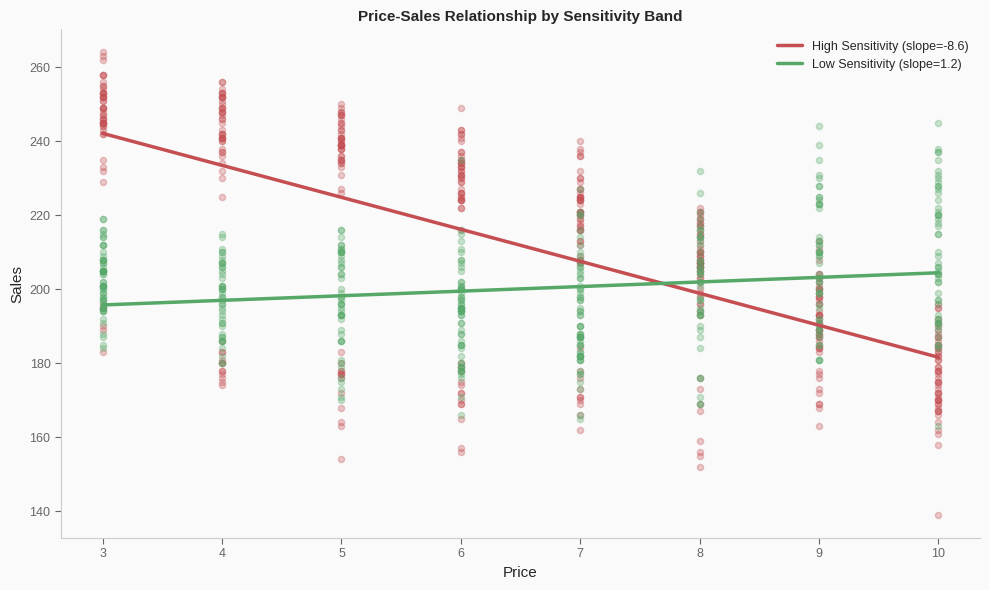


Visual confirms: High sensitivity band has steeper negative slope!


In [11]:
# Visualize the bands with price-sales relationship
import seaborn as sns

fig, ax = create_tufte_figure(1, 1, figsize=(10, 6))

# Use seaborn for regression plots by band
for i, band in enumerate(['High Sensitivity', 'Low Sensitivity']):
    subset = test_m3[test_m3['sens_band'] == band]
    color = COLORS['red'] if band == 'High Sensitivity' else COLORS['green']
    
    # Scatter
    ax.scatter(subset['price'], subset['sales'], alpha=0.3, s=20, c=color)
    
    # Regression line
    z = np.polyfit(subset['price'], subset['sales'], 1)
    p = np.poly1d(z)
    x_range = np.linspace(subset['price'].min(), subset['price'].max(), 100)
    ax.plot(x_range, p(x_range), c=color, lw=2.5, label=f'{band} (slope={z[0]:.1f})')

ax.set_xlabel('Price', fontsize=11)
ax.set_ylabel('Sales', fontsize=11)
ax.set_title('Price-Sales Relationship by Sensitivity Band', fontweight='bold')
ax.legend(frameon=False)

plt.tight_layout()
plt.show()

print("\nVisual confirms: High sensitivity band has steeper negative slope!")

```
Key Takeaways ───────────────────────────────────────────

1. Sensitivity is predicted, not observed
   - Use numerical derivative: [f(T+h) - f(T)] / h
   - Works with any model that predicts E[Y|X,T]

2. Interaction terms create heterogeneity
   - No interactions: τ(x) = β₁ (constant)
   - With interactions: τ(x) = β₁ + β₃·x (varies)

3. Model comparison
   - M1 (ATE): same prediction for everyone
   - M2 (temp): varies with temperature
   - M3 (full): varies with temp, cost, weekday
   
4. Practical use: Create sensitivity bands
   - Segment by predicted CATE
   - Personalize treatment (pricing) by segment
─────────────────────────────────────────────────────────
```

---

## 5. Interview Appendix

### Practice Questions

**Q1 (Meta E5, DS)**: *"How do you predict treatment effect heterogeneity using linear regression?"*

<details>
<summary>Solution</summary>

**Key technique: Interaction terms**

Start with base model (constant effect):
$$Y = \beta_0 + \beta_1 T + \beta_2 X + \epsilon$$

Add interaction:
$$Y = \beta_0 + \beta_1 T + \beta_2 X + \beta_3 (T \cdot X) + \epsilon$$

Now CATE varies with X:
$$\tau(x) = \frac{\partial Y}{\partial T} = \beta_1 + \beta_3 x$$

**For prediction**:

1. Fit the interaction model on training data
2. For new unit with features $x$:
   - Predict $\hat{Y}(x, T=1)$ and $\hat{Y}(x, T=0)$
   - CATE = difference
   - Or use derivative formula directly: $\hat{\beta}_1 + \hat{\beta}_3 x$

**Numerical approximation** (general):
$$\hat{\tau}(x) = \frac{\hat{Y}(x, T+h) - \hat{Y}(x, T)}{h}$$

</details>

---

**Q2 (Amazon L6, Econ)**: *"What are the limitations of using linear regression for CATE estimation?"*

<details>
<summary>Solution</summary>

**Limitations**:

1. **Linearity assumption**: Heterogeneity must be linear in X
   - $\tau(x) = \beta_1 + \beta_3 x$ assumes linear relationship
   - May miss complex nonlinear heterogeneity

2. **Feature engineering burden**: Must specify interactions manually
   - With many features, combinatorial explosion
   - May miss important interactions

3. **Regularization issues**: In high-dimensional settings
   - Regularization can shrink treatment effects toward zero
   - Especially problematic if treatment is weak predictor

4. **No uncertainty quantification** for CATE
   - Standard errors are for coefficients, not for CATE(x)
   - Need bootstrap or other methods

**Alternatives**:
- Meta-learners (S, T, X, R) can use flexible ML models
- Causal forests capture nonlinear heterogeneity
- Bayesian methods provide uncertainty quantification

</details>

---

**Q3 (Google L5, Quant)**: *"How do you interpret the coefficient on an interaction term T×X?"*

<details>
<summary>Solution</summary>

In the model:
$$Y = \beta_0 + \beta_1 T + \beta_2 X + \beta_3 (T \cdot X) + \epsilon$$

**Interpretation of β₃**:

1. **As treatment effect modifier**:
   - For each unit increase in X, the treatment effect changes by β₃
   - If β₃ > 0: higher X → larger treatment effect
   - If β₃ < 0: higher X → smaller treatment effect

2. **As conditional treatment effect**:
   - When X = 0: treatment effect = β₁
   - When X = 1: treatment effect = β₁ + β₃
   - When X = x: treatment effect = β₁ + β₃·x

3. **Marginal effect of X**:
   - When T = 0: marginal effect of X on Y is β₂
   - When T = 1: marginal effect of X on Y is β₂ + β₃

**Example**: Price × Temperature interaction
- β₁ = -5 (base price effect at temp=0)
- β₃ = 0.1 (interaction)
- At 20°C: price effect = -5 + 0.1×20 = -3
- At 30°C: price effect = -5 + 0.1×30 = -2

Interpretation: Each 10°C increase reduces price sensitivity by 1 unit.

</details>

---

## 6. References

[^1]: Facure, M. (2023). *Causal Inference for the Brave and True*. Chapter 18: "Heterogeneous Treatment Effects and Personalization."

[^2]: Angrist, J. D. and Pischke, J. S. (2008). *Mostly Harmless Econometrics*. Princeton University Press. Chapter 4: "Instrumental Variables."

[^3]: Athey, S. and Imbens, G. W. (2016). Recursive partitioning for heterogeneous causal effects. *PNAS*, 113(27), 7353-7360.

[^4]: Kunzel, S. R., Sekhon, J. S., Bickel, P. J., and Yu, B. (2019). Metalearners for estimating heterogeneous treatment effects using machine learning. *PNAS*, 116(10), 4156-4165.

---

**Next**: [03. Causal vs Predictive Models](./03_causal_vs_predictive.ipynb) — Comparing CATE models with predictive models